<a href="https://colab.research.google.com/github/FlorianGelb/GNNProject/blob/K_sparse/K_Sparse.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install Wand
!apt install imagemagick

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
imagemagick is already the newest version (8:6.9.11.60+dfsg-1.3ubuntu0.22.04.3).
0 upgraded, 0 newly installed, 0 to remove and 38 not upgraded.


In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import transforms,datasets
from torch.utils.data import Dataset,DataLoader,random_split,Subset
import matplotlib.pyplot as plt
import pandas as pd
import os
from PIL import Image

In [ ]:
data = pd.read_csv('CorruptedFashionMNIST/Names.csv')
transform = transforms.ToTensor()

In [ ]:
class FashionMNISTDataset(Dataset):
    def __init__(self,dataframe,root_dir,transform=None):
        self.dataframe=dataframe
        self.root_dir = root_dir
        self.transform=transform
    def __len__(self):
        return len(self.dataframe)
    def __getitem__(self,idx):
        img_name=os.path.join(self.root_dir,self.dataframe.iloc[idx,0])
        image=Image.open(img_name)
        label=self.dataframe.iloc[idx,1]
        if self.transform:
            image=self.transform(image)
        return image,label

In [ ]:
root_dir = 'CorruptedFashionMNIST'
dataset = FashionMNISTDataset(dataframe=data,root_dir=root_dir,transform=transform)


In [ ]:
original = datasets.FashionMNIST("./", download=True)

In [ ]:
subset_size=int(0.3 * dataset.__len__())
new_dataset = []
for i in range(subset_size):
    item = dataset.__getitem__(i)
    add = transform(original[i][0])
    new_item = item + (add,)
    new_dataset.append(new_item)
dataset=new_dataset

In [ ]:

indices = torch.randperm(len(dataset)).tolist()
subset_indices = indices[:subset_size]
subset_dataset = Subset(dataset, subset_indices)

In [ ]:
# Split the subset dataset into train and test sets
train_size = int(0.8 * len(subset_dataset))  # 80% for training
test_size = len(subset_dataset) - train_size  # Remaining for testing

train_dataset, test_dataset = random_split(subset_dataset, [train_size, test_size])

# Create DataLoader instances
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=64)

In [ ]:
images,_ ,_= next(iter(train_loader))
print(images.shape)

torch.Size([64, 1, 28, 28])


In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import transforms, datasets
from torch.utils.data import Dataset, DataLoader, random_split, Subset

import os
from PIL import Image
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np


%matplotlib inline


In [ ]:
# Encoder and decoder classes

class Encoder(nn.Module):
    def __init__(self, layers_dim,k):
        super(Encoder, self).__init__()
        self.layers_dim = layers_dim
        self.k=k

        layers = []
        for i in range(len(layers_dim)-2):
            layers.append(nn.Linear(layers_dim[i], layers_dim[i+1]))
            layers.append(nn.ReLU())
        layers.append(nn.Linear(layers_dim[-2], layers_dim[-1]))
        layers.append(nn.Sigmoid())

        self.encoder = nn.Sequential(*layers)

    def forward(self, x):
        encoded = self.encoder(x)

        raw=encoded.detach().numpy()

        k=self.k
        mask = np.ones(raw.shape, dtype=bool)
        if k < raw.shape[1]:
            for i, row in enumerate(raw):
                # Find the indices of the top k elements in each row
                indices = np.argpartition(row, -k)[-k:]

                # Update the mask to set elements at indices to False
                mask[i, indices] = False
                raw[i,mask[i]]=0
        return encoded
class Decoder(nn.Module):
    def __init__(self, layers_dim):
        super(Decoder, self).__init__()
        self.layers_dim = layers_dim

        layers = []
        for i in range(len(layers_dim)-2):
            layers.append(nn.Linear(layers_dim[i], layers_dim[i+1]))
            layers.append(nn.ReLU())
        layers.append(nn.Linear(layers_dim[-2], layers_dim[-1]))

        self.decoder = nn.Sequential(*layers)
        layers.append(nn.Tanh())

    def forward(self, y):
        decoded = self.decoder(y)


        return decoded


In [ ]:
# Class for autoencoder

class Net(nn.Module):
    def __init__(self, layers,k,loss_fn=F.mse_loss, lr=1e-4, l2=0.):
        super(Net, self).__init__()
        self.layers = layers
        self.E = Encoder(layers,k)
        self.D= Decoder(layers[::-1])
        self.loss_fn = loss_fn
        self._rho_loss = None
        self._loss = None
        self.optim = optim.Adam(self.parameters(), lr=lr, weight_decay=l2)

    def forward(self, x):
        x = x.view(-1, 28*28)
        code = self.E(x)
        out = self.D(code)


        return out

    def decode(self, h):
        with torch.no_grad():
            decoded=self.D(h)
            return decoded


    def loss(self, x, target, **kwargs):
        target = target.view(-1, 28*28)
        self._loss = self.loss_fn(x, target, **kwargs)
        return self._loss






In [ ]:
# Making AEs with 16, 64 and 256 neurons in latent layer
layers=[28*28,40,25]
models = {"5": Net(layers,5), "10": Net(layers,10),"15": Net(layers,15), "20": Net(layers,20),"25": Net(layers,25)}

train_log = {k: [] for k in models}
test_log = {k: [] for k in models}

In [ ]:

def train(epoch, models, log=None):
    train_size = len(train_loader.sampler)
    for batch_idx, (data, _,origianl) in enumerate(train_loader):
        for model in models.values():
            model.optim.zero_grad()
            inputs = data.clone().detach()
            output = model(inputs)

            loss = model.loss(output, origianl)
            loss.backward()
            model.optim.step()

        if batch_idx % 200 == 0:
            line = "Train Epoch: {} [{}/{} ({:.0f}%)]\tLosses ".format(
                epoch, batch_idx * len(data), train_size, 100. * batch_idx / len(train_loader))
            losses = " ".join(["{}: {:.6f}".format(k, m._loss.item()) for k, m in models.items()])
            print(line + losses)

    else:
        batch_idx += 1
        line = "Train Epoch: {} [{}/{} ({:.0f}%)]\tLosses ".format(
            epoch, batch_idx * len(data), train_size, 100. * batch_idx / len(train_loader))
        losses = " ".join(["{}: {:.6f}".format(k, m._loss.item()) for k, m in models.items()])
        if log is not None:
            for k in models:
                log[k].append((models[k]._loss, models[k]._rho_loss))
        print(line + losses)

In [ ]:
avg_lambda = lambda l: "loss: {:.4f}".format(l)
line = lambda i, l: "{}: ".format(i) + avg_lambda(l) + "\t"

# Test function


def test(models, loader, log=None):
    test_size = len(loader.sampler)

    test_loss = {k: 0. for k in models}

    with torch.no_grad():
        for data, _,original in loader:
            inputs = data.clone().detach()
            output = {k: m(inputs) for k, m in models.items()}
            for k, m in models.items():
                test_loss[k] += m.loss(output[k], original, reduction="sum").item()


    for k in models:
        test_loss[k] /= (test_size * 784)

        if log is not None:
            log[k].append((test_loss[k]))

    lines = "\n".join([line(k, test_loss[k]) for k in models]) + "\n"
    report = "Test set:\n" + lines
    print(report)

In [ ]:
for epoch in range(1, 50):
    for model in models.values():
        model.train()
    train(epoch, models, train_log)

    for model in models.values():
        model.eval()
    test(models, test_loader, test_log)


Train Epoch: 1 [0/14400 (0%)]	Losses 5: 0.241333 10: 0.235282 15: 0.241604 20: 0.247385 25: 0.263076
Train Epoch: 1 [12800/14400 (89%)]	Losses 5: 0.128102 10: 0.127252 15: 0.127079 20: 0.115676 25: 0.127290
Train Epoch: 1 [14400/14400 (100%)]	Losses 5: 0.134594 10: 0.129555 15: 0.127804 20: 0.111346 25: 0.128288
Test set:
5: loss: 0.1322	
10: loss: 0.1274	
15: loss: 0.1270	
20: loss: 0.1118	
25: loss: 0.1262	

Train Epoch: 2 [0/14400 (0%)]	Losses 5: 0.117308 10: 0.114450 15: 0.114518 20: 0.100954 25: 0.114288
Train Epoch: 2 [12800/14400 (89%)]	Losses 5: 0.106233 10: 0.102505 15: 0.100891 20: 0.099201 25: 0.100716
Train Epoch: 2 [14400/14400 (100%)]	Losses 5: 0.087275 10: 0.084832 15: 0.083791 20: 0.082870 25: 0.084213
Test set:
5: loss: 0.0915	
10: loss: 0.0888	
15: loss: 0.0875	
20: loss: 0.0865	
25: loss: 0.0877	

Train Epoch: 3 [0/14400 (0%)]	Losses 5: 0.078253 10: 0.076622 15: 0.075758 20: 0.075503 25: 0.076643
Train Epoch: 3 [12800/14400 (89%)]	Losses 5: 0.084521 10: 0.082015 15: 

Plots of loss on validation set show smooth decrease of reconstruction and rho loss (for 256 latent dimensions and 50 epochs training). The model did not overfit on train data.

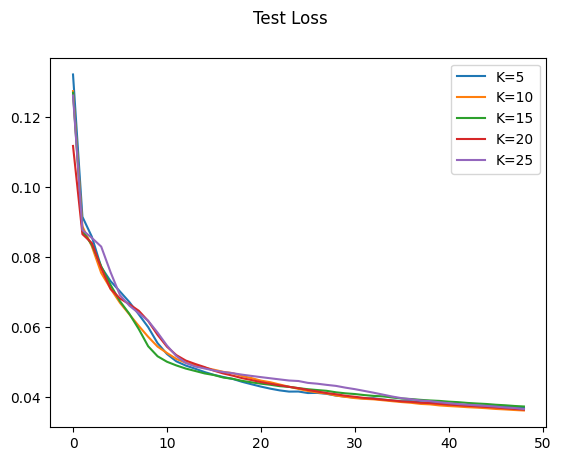

In [ ]:
for k in test_log:
    plt.plot(test_log[k], label=f'K={k}')

plt.legend()
plt.suptitle('Test Loss')
plt.show()


In [ ]:
import matplotlib
%matplotlib inline
import matplotlib.pyplot as plt


In [ ]:
data, _,_ = next(iter(test_loader))
to_plots={k: [] for k in models}
encode={k: [] for k in models}
for k in models:
  output = models[k](data)

  to_plot = output.view(-1, 1, 28, 28).clamp(0, 1).data.numpy()
  to_plots[k].append(to_plot)

  x = data.view(-1, 28*28)
  encode[k].append(models[k].E(x))


In [ ]:
def plot_mnist(images,title, shape):
    fig = plt.figure(figsize=shape[::-1], dpi=150)
    num_images = min(len(images), shape[0] * shape[1])

    for j in range(1, num_images + 1):
        ax = fig.add_subplot(shape[0], shape[1], j)
        ax.matshow(images[j - 1, 0, :, :], cmap=matplotlib.cm.binary)
        plt.xticks(np.array([]))
        plt.yticks(np.array([]))
    plt.suptitle(title)
    plt.show()

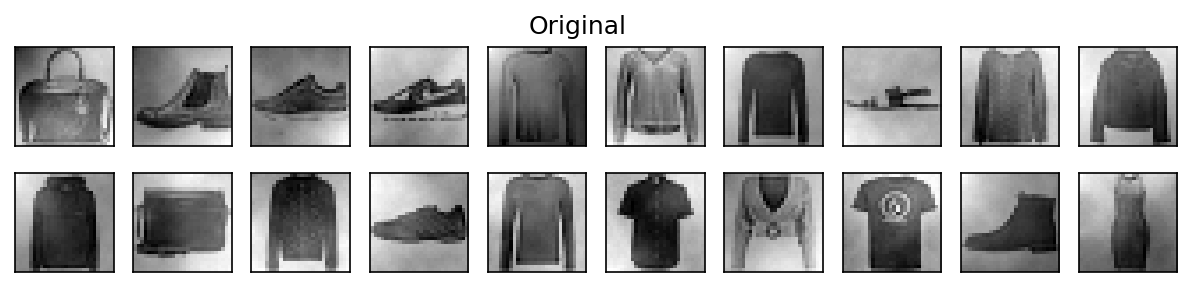

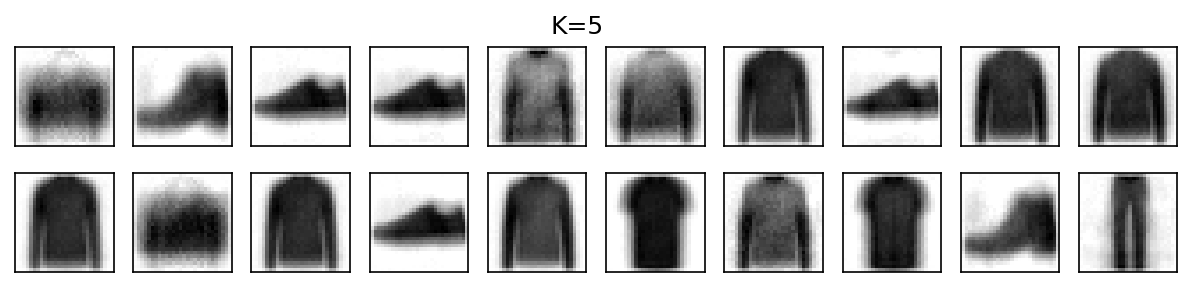

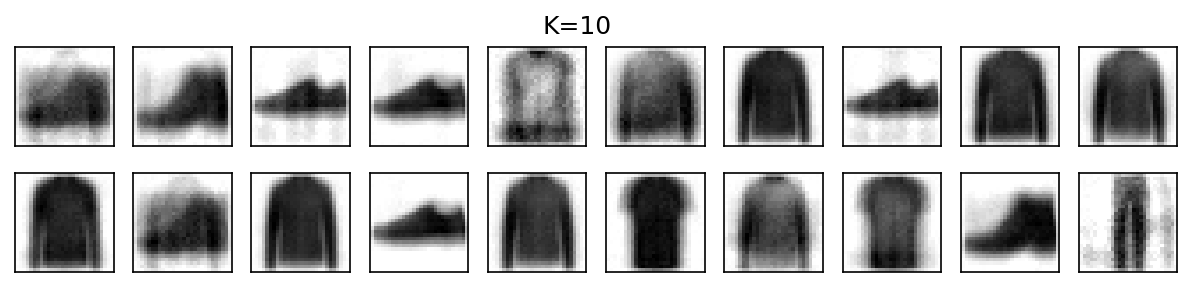

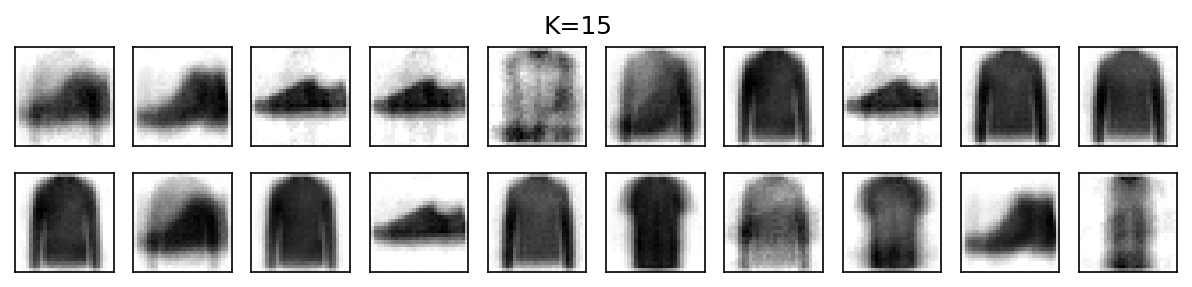

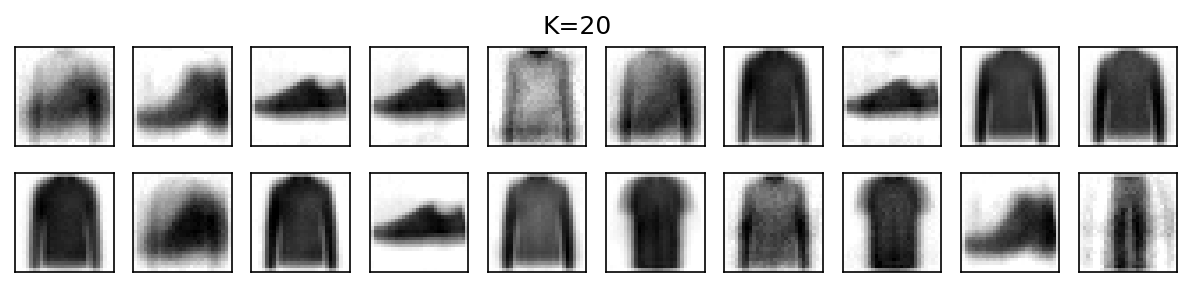

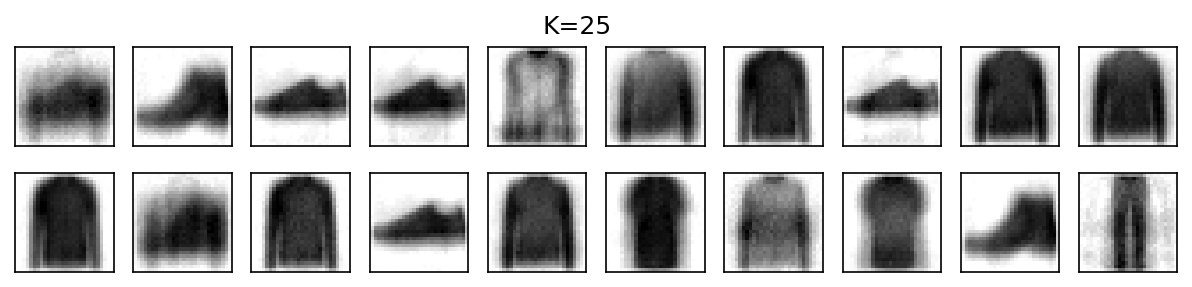

In [ ]:
plot_mnist(data.data.numpy(),"Original" ,(2, 10))
for k in to_plots:
  plot_mnist(to_plots[k][0], f'K={k}', (2, 10))